In [1]:
import pyodbc 
import numpy as np
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from sqlalchemy import create_engine
import time


import gc
gc.collect()



cnxn = pyodbc.connect('driver={ODBC Driver 17 for SQL Server};server=*********,18000;database=IZDW;trusted_connection=yes')  
cursor = cnxn.cursor()


SQLReader  = pd.read_sql_query("select * from MYDB.stor.IZ_hotel",cnxn)
df = pd.concat(SQLReader, ignore_index=True)




df = pd.read_sql_query('''
                       
select a.customerID,isnull(CustomerLTVScore,0) CustomerLTVScore
 ,isnull(Age,0) Age
 ,isnull(a.TotalPoints,0) TotalPoints
 ,isnull(EnrolledLength,0) EnrolledLength
 ,isnull(LifetimeSpendPerDay,0) LTSPEND
 ,case when R6LocationPreference is null then 'No Spend' else R6LocationPreference end R6LocationPreference
 ,isnull(LT_sepnd,0) LT_sepnd ,isnull(LT_Roomoffergiven,0) LT_Roomoffergiven,isnull(LT_RI,0) LT_RI
,isnull(R24_Spend,0) R24_spend,isnull(R24_Roomoffergiven,0) R24_Roomoffergiven,isnull(R24_RI,0) R3_RI
,isnull(R12_spend,0) R12_spend ,isnull(R12_Roomoffergiven,0) R12_Roomoffergiven,isnull(R12_RI,0) R3_RI
,isnull(R6_spend,0) R6_spend,isnull(R6_Roomoffergiven,0) R6_Roomoffergiven,isnull(R6_RI,0) R6_RI
,isnull(R3_spend,0) R3_spend,isnull(R3_Roomoffergiven,0) R3_Roomoffergiven,isnull(R3_RI,0) R3_RI
                 ,isnull(LT_Freqcount,0) LT_Freqcount
                , isnull(datediff(dd,LastPurchaseDate,getdate()-1),99999) recency
                       from customer_dim a
                       left join PlayerLatestInfo_rpt b on a.dim_Player_key=b.dim_Player_key 
  left join (select distinct customerID
     ,  sum(Roomoffergiven) LT_Roomoffergiven
  ,sum(Totalfreebies+Totalpromotion+loyaltypoints)/ isnull(sum(nullif(spendamount,0)),1) LT_RI
   , sum(spendamount) LT_sepnd
                       , sum(Freqcount)  LT_Freqcount
                       from transaction_db group by customerID) c on a.customerID=c.customerID 
                       left join (select distinct customerID  
  ,  sum(Roomoffergiven) R24_Roomoffergiven
   ,sum(Totalfreebies+Totalpromotion+loyaltypoints)/ isnull(sum(nullif(spendamount,0)),1) R24_RI
   , sum(spendamount)/ nullif(count(distinct case when spendamount>0 then transactiondate end),0)  R24_Spend from transaction_db where transactiondate between dateadd(mm,-12,convert(date,getdate()-1)) and convert(date,getdate()-1) group by customerID) R24 on a.customerID=R24.customerID 
                       left join (select distinct customerID  
   ,  sum(Roomoffergiven) R12_Roomoffergiven
   ,sum(Totalfreebies+Totalpromotion+loyaltypoints)/ isnull(sum(nullif(spendamount,0)),1) R12_RI
   , sum(spendamount) / nullif(count(distinct case when spendamount>0 then transactiondate end),0) R12_spend from transaction_db where transactiondate between dateadd(mm,-12,convert(date,getdate()-1)) and convert(date,getdate()-1) group by customerID) R12 on a.customerID=R12.customerID 
                       left join (select distinct customerID
     ,  sum(Roomoffergiven) R6_Roomoffergiven
   ,sum(Totalfreebies+Totalpromotion+loyaltypoints)/ isnull(sum(nullif(spendamount,0)),1) R6_RI
   , sum(spendamount) / nullif(count(distinct case when spendamount>0 then transactiondate end),0)  R6_spend from transaction_db where transactiondate between dateadd(mm,-6,convert(date,getdate()-1)) and convert(date,getdate()-1) group by customerID) R6 on a.customerID=R6.customerID 
   left join (select distinct customerID
  ,  sum(Roomoffergiven) R3_Roomoffergiven
   ,sum(Totalfreebies+Totalpromotion+loyaltypoints)/ isnull(sum(nullif(spendamount,0)),1) R3_RI
  ,sum(spendamount) / nullif(count(distinct case when spendamount>0 then transactiondate end),0)  R3_spend from transaction_db where transactiondate between dateadd(mm,-3,convert(date,getdate()-1)) and convert(date,getdate()-1) group by customerID) R3 on a.customerID=R3.customerID 

   where RealcustomerFlag = 1 and a.StatusCode <> 'M'
                                            
                      ''',cnxn)

df.columns.values.tolist ()

In [3]:
palette = ["#008248", "#bdc9dd","#604c4c", "#eac784", "#f0cddb", "#6B9997", "#4462D1"]
PropertyPreference = ["#8700f9", "#00c4a9"]


sns.set_palette(sns.color_palette(palette))

#df2 = df[['R6LocationPreference','CustomerLTVScore','LT_sepnd', 'R24_spend', 'R12_spend', 'R3_spend']].query('R6LocationPreference in ["Cot Predom", "MA Predom","Cross Property","No Spend"]')
#df2['R6LocationPreference'] = df2['R6LocationPreference'].map({'MA Predom': 'MA', 'Cot Predom': 'Cot'})
#g = sns.pairplot(df2, hue='R6LocationPreference')
#g.fig.suptitle();

In [4]:
#feature scalling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler().fit(df.iloc[0:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]])
df_scaled = scaler.transform(df.iloc[0:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]])
df_scaled.std(axis=0)[:5], df_scaled.mean(axis=0)[:5]

df.iloc[0:,[1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]].columns.values.tolist ()

['CustomerLTVScore',
 'Age',
 'TotalPoints',
 'EnrolledLength',
 'LTSPEND',
 'LT_sepnd',
 'LT_Roomoffergiven',
 'LT_RI',
 'R24_spend',
 'R24_Roomoffergiven',
 'R3_RI',
 'R12_spend',
 'R12_Roomoffergiven',
 'R3_RI',
 'R6_spend',
 'R6_Roomoffergiven',
 'R6_RI',
 'R3_spend',
 'R3_Roomoffergiven',
 'R3_RI',
 'LT_Freqcount',
 'recency']

In [13]:
df.head(n=5)

,customerID,CustomerLTVScore,Age,TotalPoints,EnrolledLength,LTSPEND,R6LocationPreference,LT_sepnd,LT_Roomoffergiven,LT_RI,...,R12_Roomoffergiven,R3_RI,R6_spend,R6_Roomoffergiven,R6_RI,R3_spend,R3_Roomoffergiven,R3_RI,LT_Freqcount,recency
0,11627107,101.0,38,0.0,3.42,60380.4208,MA Predom,1.267989e+06,16100.0,0.1552,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,668,1188
1,10785907,95.4,50,12743.0,8.78,60379.4852,MA Predom,8.755025e+06,355042.5,0.1320,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,13025,493
2,10872888,100.0,53,3383.0,7.98,60366.2216,MA Predom,3.621973e+05,1317.5,0.1812,...,1317.5,0.2629,57977.4400,1317.5,0.2629,72027.6550,0.0,0.2406,19234,13
3,10213560,93.0,55,46206.0,13.10,60341.3143,Cot Predom,1.387850e+06,-3200.0,0.1447,...,0.0,0.3552,27410.0948,0.0,0.4223,30195.4508,0.0,0.9566,890,13
4,11826882,100.0,39,6556.0,3.00,60322.7116,Cot Predom,1.206454e+06,44310.0,0.3209,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,14183,966


In [5]:
#Dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(df_scaled)


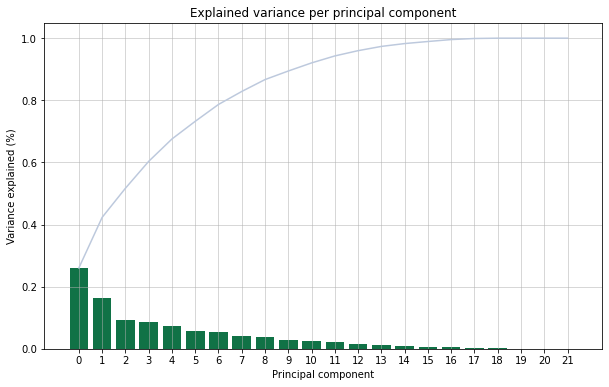

In [6]:
# Scree plot (variance explained by each principal component)
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

plt.figure(figsize=(10,6))

ax = sns.barplot(ind, vals, palette=palette[:1], ci=None)
ax2 = sns.lineplot(ind, cumvals, color=palette[1], ci=None)
ax.grid(b=True, which='major', linewidth=0.7)

ax.set_xlabel("Principal component analysis")
ax.set_ylabel("variance explained (%)")
plt.title('variance explained per principal component');



In [10]:
# be selective on choosing PCA with components that explain 80% of the variance

cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.8])
pca = PCA(num_components).fit(df_scaled)
X_pca = pca.transform(df_scaled)
X_pca = pd.DataFrame(X_pca)

print(num_components)
np.cumsum(pca.explained_variance_ratio_)

7


array([0.26040133, 0.42313797, 0.51680274, 0.60339884, 0.67546888,
       0.73229678, 0.78663551])

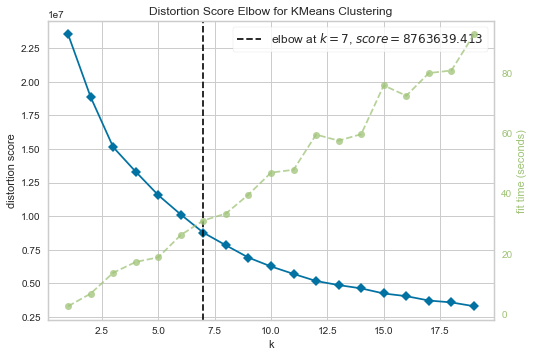

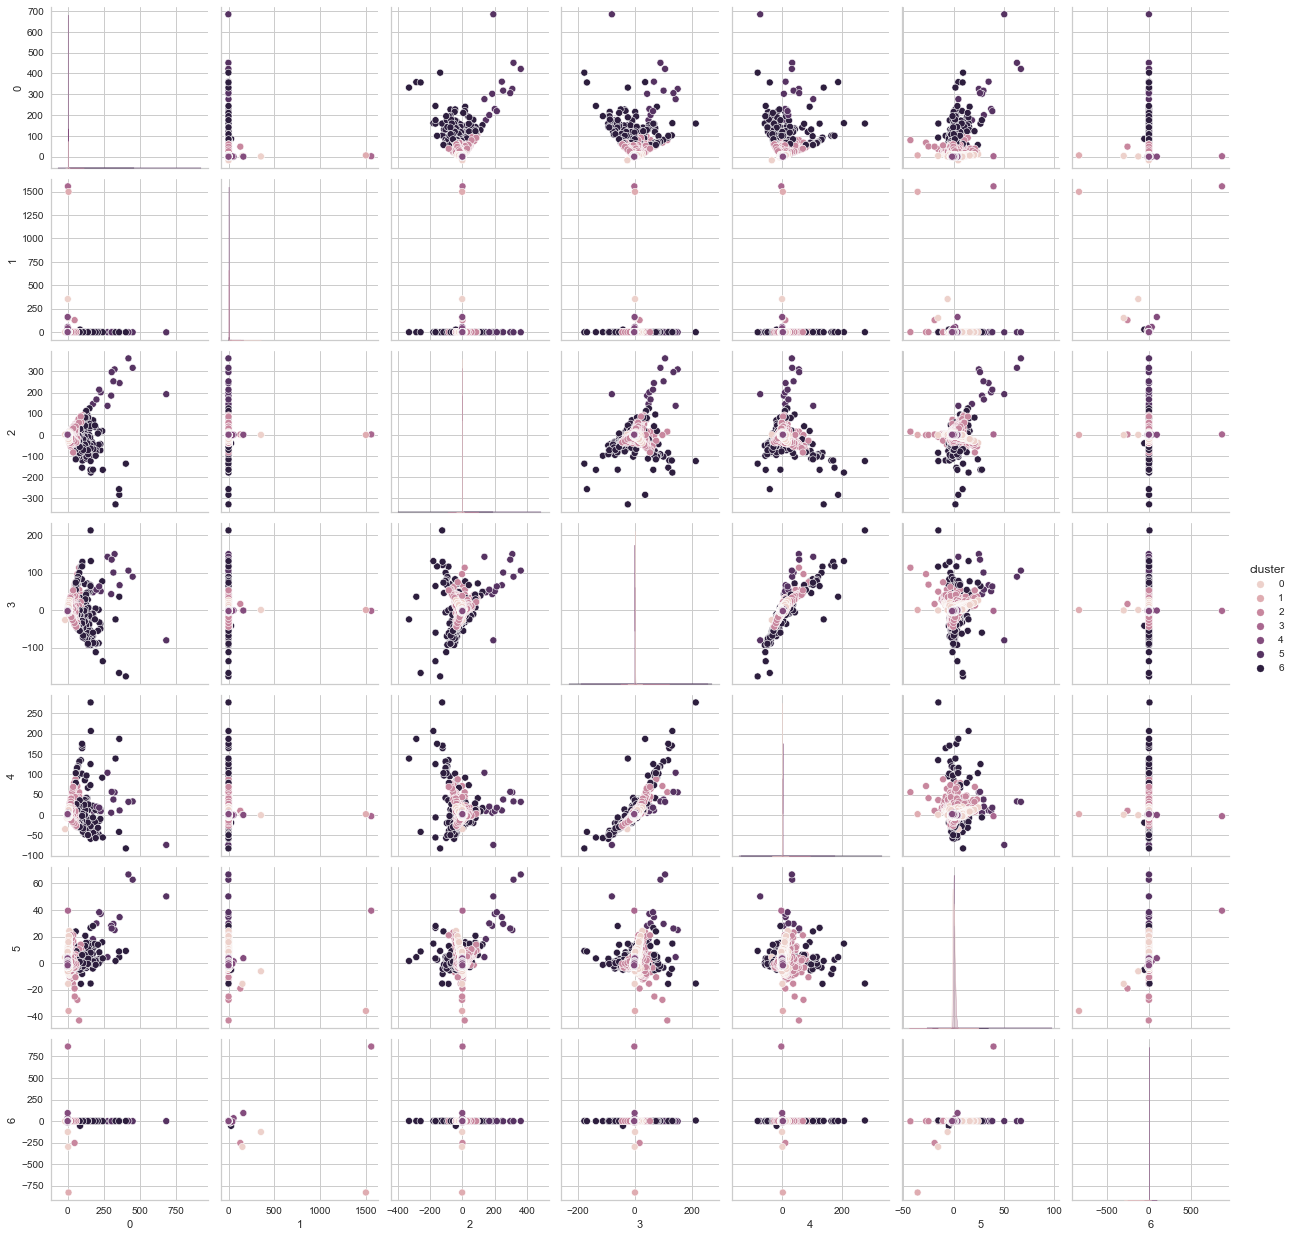

In [11]:
# elbow method to determine number of clusters for kmeans
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(X_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


#kelbow_visualizer(KMeans(k=6),X_pca)
#kelbow_visualizer(KMeans(), X_pca, k=(2,6), metric='silhouette')

model = KMeans(n_clusters=7, random_state=28).fit(X_pca)
kmeans_clusters = model.predict(X_pca)

#X_pca_c = X_pca.copy()
#X_pca_c['cluster'] = kmeans_clusters
X_pca['cluster'] = kmeans_clusters
sns.pairplot(X_pca, hue='cluster')

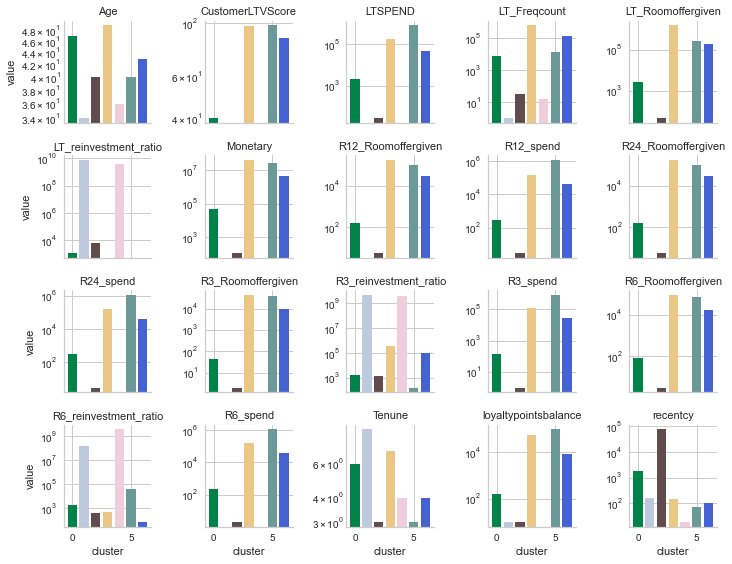

In [8]:

final_df = df.iloc[0:,[0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]].copy().reset_index()
final_df['cluster'] = kmeans_clusters
final_df = final_df.iloc[0:,1:].melt(id_vars=['customerID', 'cluster'])
#final_df = final_df.query('variable== "R3_spend"').groupby(['cluster','variable']).mean('value').rename(columns={'customerID':'avg'}).reset_index()
final_df = final_df.groupby(['cluster','variable'])['value'].mean().reset_index()
#final_df = final_df.query('variable== "R3_spend').groupby(['cluster', 'variable']).mean().reset_index()
#final_df["avg"]=final_df["avg"].round(5)
#final_df["avg"].dtype
final_df["value"]=final_df["value"].astype('int64')

g = sns.FacetGrid(final_df, col='variable', hue='cluster', palette=palette, col_wrap=5, height=2, sharey=False)
g = g.map(plt.bar, 'cluster', 'value').set_titles("{col_name}").set(yscale = 'log');


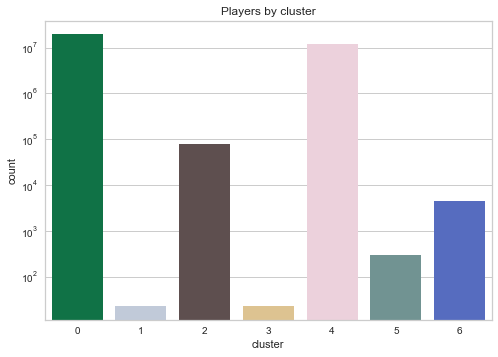

In [16]:
final_df2 = df.iloc[0:,[0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]].copy().reset_index()
final_df2['cluster'] = kmeans_clusters
final_df2 = final_df2.melt(id_vars=['customerID', 'cluster'])
#final_df2 = final_df2.groupby(['cluster'])['customerID'].count().reset_index()


ax = sns.countplot(x='cluster', data=final_df2,palette=palette)
ax.set_yscale('log')
ax.set_title('Players by cluster');


In [ ]:
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.expand_frame_repr', False)

X_pca_c.head()
final_df.tail(10000)